# Lab Assignment 2

**Computer Vision** - Term 5, 2023

Instructor: Dr. Saumya Jetley <br>
TA: Ribhu Lahiri, Raghav Awasty

For reference: 
* Define a filter (matrix of values) that can be convolved with the input image to extract different kinds of frequency information from the image.
* Implement the Sobel, Canny and Laplace edge detectors.
* Modify the filter values to create new filters and observe the output when convolved with the input image.


In [39]:
# Imports 
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [41]:
# Reading in a sample image
import gdown

id = "1oIK5OKyx-J82R0LR2g3-8w7YAUB-L6ra"
gdown.download(id=id, output='cube.jpeg', quiet=True)

id = "1oO2uY_bZhD9O9F45F8jZ0HBYmv9vIUo9"
gdown.download(id=id, output='einstein.jpeg', quiet=True)

im = cv2.imread("./cube.jpeg", 0)

**Implement the convolve function** *(1 point)*

Use the helper method `window` to create a function that uses the sliding window to convolve over a given image.

In [42]:
# Task: 

def window(receptive_field, filter):
    ''' 
    Convolves a filter over the receptive field from the image

    Parameters
    ----------
    receptive_field: np.ndarray
        The portion of the image the convolution is being done over

    filter: np.ndarray
        The defined filter

    Returns
    -------
    np.ndarray
        The convolved receptive field output
    '''
  
    return np.sum(filter * receptive_field)
    
def convolve(image, kernel):
    ''' 
    Convolves the filter over the image (sliding window)

    Parameters
    ----------
    image: np.ndarray
        The image as a 2-dimensional matrix

    kernel: np.ndarray
        The defined filter

    Returns
    -------
    output_image: np.ndarray
        The image after convolving the filter over it
    '''

    # Here I am doing the convolution with the zero padding to preseve the image shape

    #step1:  zero pad the input image: Assuming both image and kernal are square shaped
    pw = kernel.shape[0]//2  
    shape = image.shape

    image = np.pad(image, pad_width = pw, mode = "constant")

    #step2: initialize the output:
    output = np.zeros(shape)

    #step 3: interatively convolve:
    for i in range(pw,shape[0]+pw):
      for j in range(pw,shape[1]+pw):
        output[i-pw,j-pw] = window(image[i-pw:i+pw+1,j-pw:j+pw+1],kernel)
    
    return output    

Sample sharpen filter to check functionality

In [43]:
image_array = np.asarray(im)

# Sharpen
filter = np.array(([0, -1, 0], 
                   [-1, 7, -1], 
                   [0, -1, 0]))

In [44]:
filtered_im = convolve(image_array, filter)

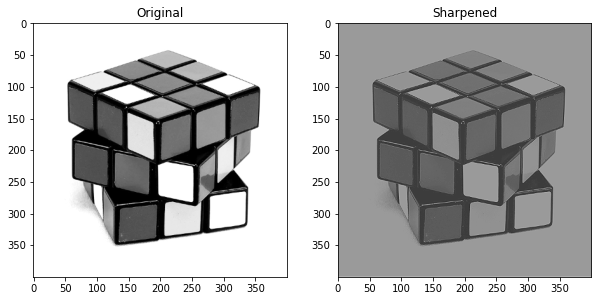

In [45]:
fsize = (10, 6)
plt.figure(figsize = fsize)
plt.subplot(121),plt.imshow(im, 'gray'), plt.title('Original')
plt.subplot(122),plt.imshow(filtered_im, 'gray'), plt.title('Sharpened')
plt.show()

## Sobel filters to check functionality

- Converting the image into grayscale
- Convolving the gray image with Sobel-x filter
- Convolving the gray image with Sobel-y filter
- Calculating the gradient magnitude and direction

In [46]:
# Sobel filters
sobel_x = np.array([[-1, 0, 1], 
                    [-2, 0, 2], 
                    [-1, 0, 1]])

sobel_y = np.array([[-1, -2, -1], 
                    [0, 0, 0], 
                    [1, 2, 1]])

# gaussian_1d = np.array([1, 2, 1],np.float32)
# x_derivative = np.array([-1, 0, 1],np.float32)
# s_x = np.outer(gaussian_1d, x_derivative)  
# s_y = np.outer(x_derivative, gaussian_1d)

filtered_v = convolve(image_array, sobel_x)
filtered_h = convolve(image_array, sobel_y)

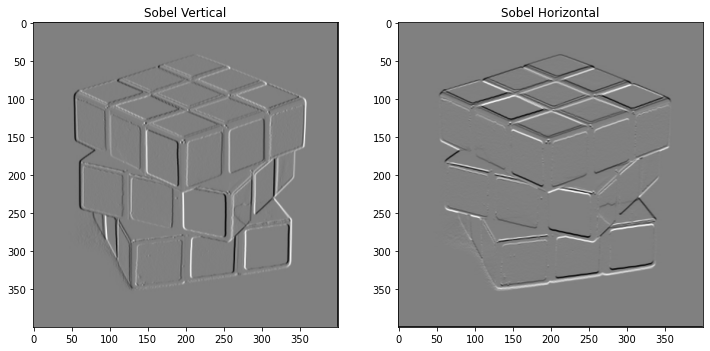

In [47]:
fsize = (12,8)
plt.figure(figsize = fsize)
plt.subplot(121), plt.imshow(filtered_v, 'gray'), plt.title('Sobel Vertical')
plt.subplot(122), plt.imshow(filtered_h, 'gray'), plt.title('Sobel Horizontal')
plt.show()

In [48]:
# Combining them to get the gradients magnitude (scales intensities b/w 0 and max)
sobel_manual = np.sqrt(filtered_h**2 + filtered_v**2)

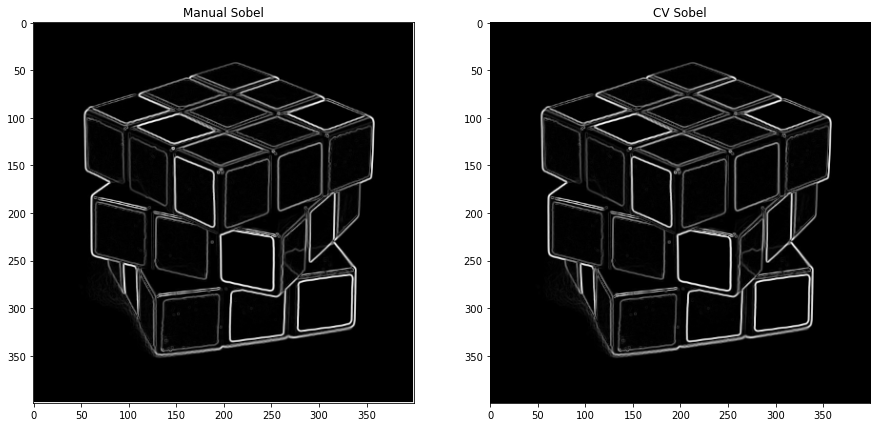

In [49]:
# Using the CV2 module
sobel_x_cv = cv2.Sobel(image_array,cv2.CV_64F, 1, 0, ksize=3)
sobel_y_cv = cv2.Sobel(image_array,cv2.CV_64F, 0, 1, ksize=3)
sobel_cv = np.hypot(np.absolute(sobel_x_cv), np.absolute(sobel_y_cv))

fsize = (15, 8)
plt.figure(figsize=fsize)
plt.subplot(121), plt.imshow(sobel_manual, 'gray'), plt.title('Manual Sobel')
plt.subplot(122), plt.imshow(sobel_cv, 'gray'), plt.title('CV Sobel')
plt.show()

## Canny edge-detection step:

### 1. Apply Gaussian Kernel to **smooth edges**

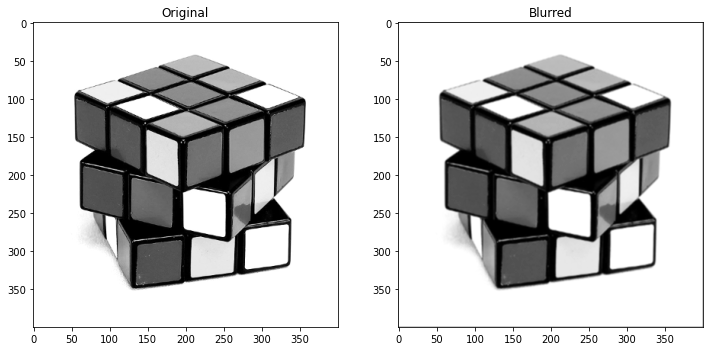

In [50]:
# Applying gaussian blurring
gaussian = np.array([[1, 2, 1],
                     [2, 4, 2],
                     [1, 2, 1]]) / 16

blurred = convolve(image_array, gaussian)

fsize = (12,8)
plt.figure(figsize = fsize)
plt.subplot(121), plt.imshow(im, 'gray'), plt.title('Original')
plt.subplot(122), plt.imshow(blurred, 'gray'), plt.title('Blurred')
plt.show()

### 2. Apply Sobel filter to **find gradients**
    
- Gradient Magnitude: 
$$Gm = \sqrt{x^2 + y^2}$$
    
- Gradient Direction
$$Gd = arctan(y/x)$$

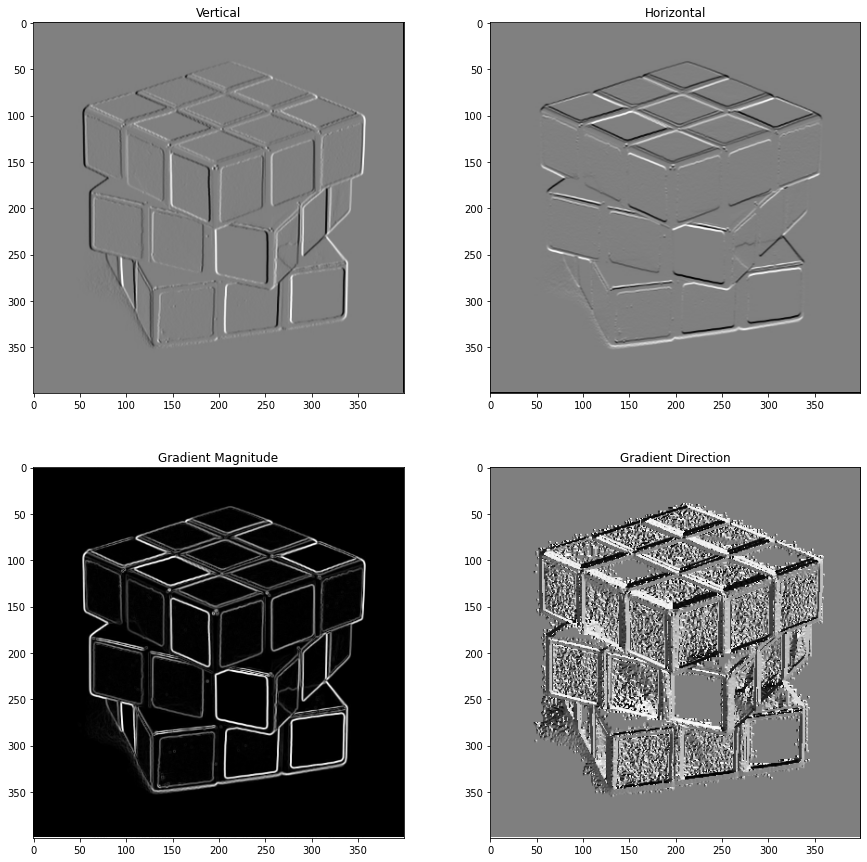

In [51]:
# Applying the sobel filter to detect edges
filtered_v = convolve(im, sobel_x)
filtered_h = convolve(im, sobel_y)

# Finding the gradient magnitude and direction to be passed to NMS
Gm = (filtered_v**2 + filtered_h**2)**0.5
scaler = MinMaxScaler()
Gm = scaler.fit_transform(Gm)
Gm = Gm*255

Gd = np.rad2deg(np.arctan2(filtered_v, filtered_h))

fsize = (15, 15)
plt.figure(figsize = fsize)
plt.subplot(221), plt.imshow(filtered_v, 'gray'), plt.title('Vertical')
plt.subplot(222), plt.imshow(filtered_h, 'gray'), plt.title('Horizontal')
plt.subplot(223), plt.imshow(Gm, 'gray'), plt.title('Gradient Magnitude')
plt.subplot(224), plt.imshow(Gd, 'gray'), plt.title('Gradient Direction')
plt.show()

In [52]:
Gd%180

array([[ 45.,   0.,   0., ...,   0.,   0., 135.],
       [ 90.,   0.,   0., ...,   0.,   0.,  90.],
       [ 90.,   0.,   0., ...,   0.,   0.,  90.],
       ...,
       [ 90.,   0.,   0., ...,   0.,   0.,  90.],
       [ 90.,   0.,   0., ...,   0.,   0.,  90.],
       [135.,   0.,   0., ...,   0.,   0.,  45.]])

### 3. Non-maximum suppression for **edge thinning (preserves the sharpest gradients and discards the others)** *(1 point)*

- Check every pixel on the Gradient magnitude image and choose 2 neighbor of the pixel according to Gradient Direction. If center pixel is larger than the both neighbors then keep it, otherwise set the pixel to 0

```
for each pixel:
    pick the neighbouring pixels based on gradient direction
    if pixel value > neighbouring pixels:
        pixel value == pixel value
    else:
        pixel value == 0
```

In [53]:
Gm

array([[255., 255., 255., ..., 255., 255., 255.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [255., 255., 255., ..., 255., 255., 255.]])

In [54]:
# Applying NMS to make edges consistent
def f_NMS(Gm, Gd):
    ''' 
    Applies non-maximal supression to the gradient magnitude using the gradient direction

    Parameters
    ----------
    Gm: np.ndarray
        The gradient magnitude

    Gd: np.ndarray
        The gradient directions

    Returns
    -------
    np.ndarray
        The image with supressed edges
    '''
    
    # step1: preprocess the Gd to remove the negative values:
    Gd = Gd%180
    def func(x): #this function thresholds the angles
      if x<=22.5:
        return 0
      elif x<=67.5:
        return 45
      elif x<=112.5:
        return 90
      else:
        return 135
    vec_fn = np.vectorize(func) #conver t the function to a vector function to apply over the entire array
    Gd = vec_fn(Gd)

    #step2: initialzing the output:
    # output = np.zeros(Gm.shape)
    shape = Gm.shape


    #for easy computation:
    d = {
        0: [(-1,0),(1,0)],
       45: [(-1,-1),(1,1)],
       90: [(0,-1),(0,1)],
      135: [(-1,1),(1,-1)]
    }

    Gm = np.pad(Gm,pad_width = 1, mode = "constant")

    #step3: comparisions:
    for i in range(1,shape[0]+1):
      for j in range(1,shape[1]+1):
        i1 = d[Gd[i-1,j-1]][0][0]
        i2 = d[Gd[i-1,j-1]][1][0]
        j1 = d[Gd[i-1,j-1]][0][1]
        j2 = d[Gd[i-1,j-1]][1][1]
        if Gm[i,j] > Gm[i+i1 ,j+j1] and Gm[i,j] > Gm[i+i2 , j +j2]:
          Gm[i,j] = Gm[i,j]
        else:
          Gm[i,j] = 0
    
    Gm = Gm[1:-1,1:-1] #removing the padding
    
    return Gm

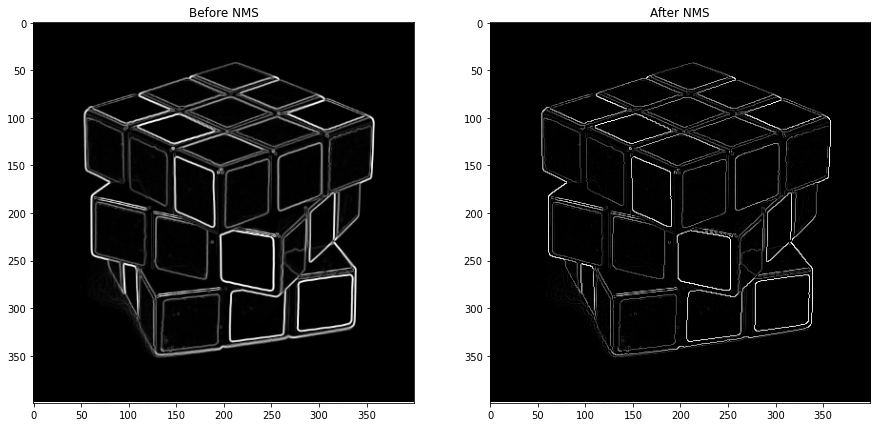

In [55]:
G_NMS = f_NMS(Gm, Gd)
fsize = (15,8)
plt.figure(figsize = fsize)
plt.subplot(121), plt.imshow(Gm, 'gray'), plt.title('Before NMS')
plt.subplot(122), plt.imshow(G_NMS, 'gray'), plt.title('After NMS')
plt.show()

In [56]:
G_NMS

array([[255., 255., 255., ..., 255., 255., 255.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [255., 255., 255., ..., 255., 255., 255.]])

### 4. Double thresholding to **preserve strong/relevant edges** *(1 point)*

```
For each pixel:
    if pixel value < lower threshold:
        pixel value == 0
    elif pixel value > higher threshold:
        pixel value == strong (255)
    else:
        pixel value == weak
        hysteresis pass
```

In [57]:
# Double threshold to remove weak edges and preserve all other edges
def threshold(img, lb, hb):
    ''' 
    Filter the strong and relevant edges from the gradient magnitude 
    and removes weak edges based on a high and low threshold value

    Parameters
    ----------
    img: np.ndarray
        The gradient magnitude

    lowThresholdRatio: float
        The fraction of either the max/mean intensity to create the low threshold

    highThresholdRatio: float
        The fraction of either the max/mean intensity to create the high threshold

    Returns
    -------
    res: np.ndarray
        The image with the filtered pixel intensities

    weak: int
        The value set for the weak pixels to be passed to the hysterisis mechanism

    strong: int
        The value set for the strong pixels to be passed to the hysterisis mechanism
    '''
    img = img.astype("uint8")
    
    # calculating the thresholds:
    image = np.zeros(img.shape)

    for i in range(img.shape[0]):
      for j in range(img.shape[1]):
        val = img[i,j]
        if val < lb:
          image[i,j] = 0
        elif val >hb:
          image[i,j] = 255
        else:
          image[i,j] = val

    return image,lb,hb
    

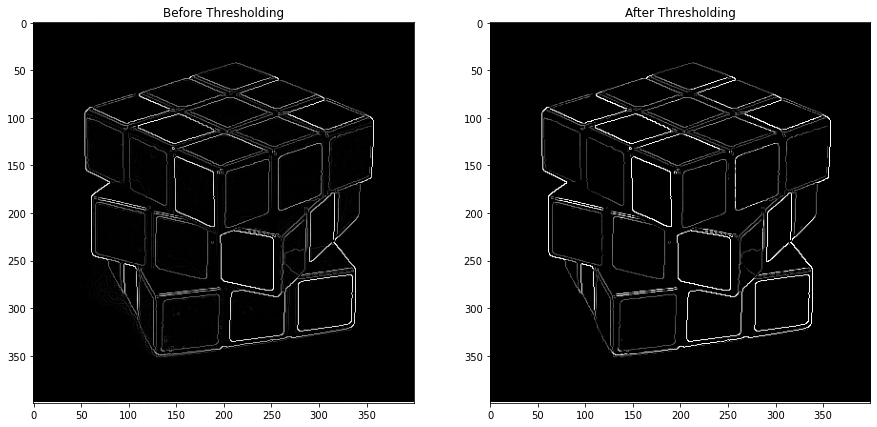

In [58]:
res, weak, strong = threshold(G_NMS, 50,150)

fsize = (15,8)
plt.figure(figsize = fsize)
plt.subplot(121), plt.imshow(G_NMS, 'gray'), plt.title('Before Thresholding')
plt.subplot(122), plt.imshow(res, 'gray'), plt.title('After Thresholding')
plt.show()

### 5. Hysteresis Thresholding to **find the relevant weak edges** *(1 point)*
- Weak edges can be caused by noise or could be relevant,
    - *Connected to strong edges -> true edge*
    - *Not connected to strong edges -> caused by noise*

```
For each pixel:
Compare the magnitude of the pixel being processed with its eight surrounding pixels
    If at least one of these pixels belongs to the strong edges group:
        pixel value == strong (255) 
    else:
        pixel value == 0
```

In [59]:
# Hysterisis pass
def hysteresis(img, weak, strong):
    ''' 
    Filter the strong and relevant edges from the gradient magnitude 
    and removes weak edges based on a high and low threshold value

    Parameters
    ----------
    img: np.ndarray
        The gradient magnitude after double thresholding

    weak: int
        The value of the weak edges

    strong: int
        The value of the strong edges

    Returns
    -------
    np.ndarray
        The final image with only strong edges preserved
    '''
    # zero pad for easy computation:
    image = np.pad(img,pad_width = 1, mode = "constant")
    output = np.zeros(img.shape, dtype = "uint8")

    for i in range(1,img.shape[0]):
      for j in range(1,img.shape[1]):
        if image[i,j] > 20:
          output[i-1,j-1] = 255
        # if (image[i-1:i+2,j-1:j+2] >).any():
        #   output[i-1,j-1] = 255

    return output  

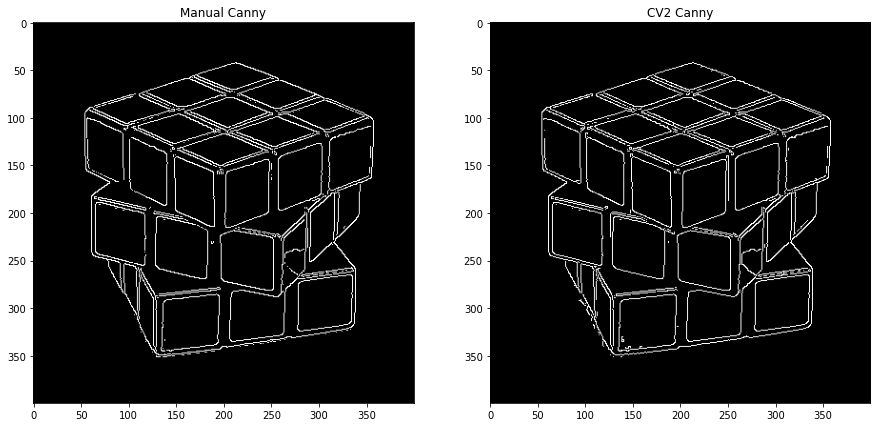

In [60]:
canny_manual = hysteresis(res, weak, strong)

# Usind the CV2 module
canny_cv = cv2.Canny(im, 100, 200)

fsize = (15,8)
plt.figure(figsize = fsize)
plt.subplot(121), plt.imshow(canny_manual, 'gray'), plt.title('Manual Canny')
plt.subplot(122), plt.imshow(canny_cv, 'gray'), plt.title('CV2 Canny')
plt.show()

## Laplacian filter

- Very sensitive to noise; countered by applying gaussian blur/smoothing to reduce the high frequency noise components
- Pair of Laplacian over Gaussian filter (LoG)

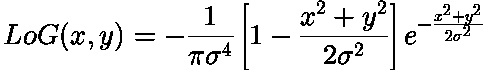

### Creating the **LoG mask** *(1 point)*

In [61]:
def create_LoG(sigma, size):
    '''
    Finds the inflection point (zero crossing point) by checking the neighborhood
    of each pixel and verifying if the sign changes compared to the pixel being processed

    Parameters
    ----------
    sigma: float
        The scale of the filter 

    size: int
        The size of the LoG filter to be applied

    Returns
    -------
    np.ndarray
        The LoG mask to be convolved over the image
    '''

    # TODO: YOUR CODE HERE
    mask = np.zeros((size,size))

    for i in range(size):
      for j in range(size):
        val = (i**2 + j**2)/(2*(sigma**2))
        x = -1*(1-val)*(np.e**(-1*val))
        x = x/np.pi
        x = x/(sigma**4)
        mask[i,j] = x
    return mask

In [62]:
# Create the LoG_mask
LoG_mask = create_LoG(1.4, 7)

# convolving with the LoG mask
LoG_image = convolve(image_array, LoG_mask)

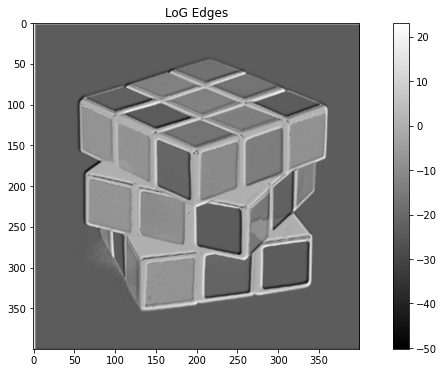

In [63]:
fsize = (12,6)
plt.figure(figsize = fsize)
plt.imshow(LoG_image, 'gray'), plt.title('LoG Edges')
plt.colorbar()
plt.show()

### Estimating edges based on the **zero-crossing** mechanism *(1 point)*

In [64]:
 def zero_cross(LoG_image):
    '''
    Finds the inflection point (zero crossing point) by checking the neighborhood
    of each pixel and verifying if the sign changes compared to the pixel being processed

    Parameters
    ----------
    LoG_image: np.ndarray
        The image convolved with the LoG filter

    Returns
    -------
    np.ndarray
        The image with zero crossing edges
    '''
    
    output = np.zeros_like(LoG_image)

    for i in range(1,output.shape[0]-1):
      for j in range(1,output.shape[1]-1):
        nei = np.sign(LoG_image[i-1:i+2,j-1:j+2]).flatten()
        if any([(n != np.sign(LoG_image[i,j])) and (n!=0) for n in nei]):
          output[i,j] = 1
    return output


In [65]:
laplacian_manual = zero_cross(LoG_image)

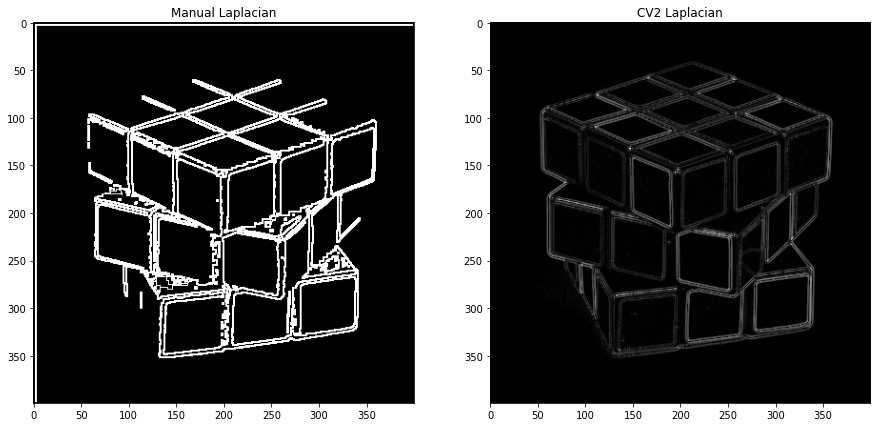

In [66]:
blur_img = cv2.GaussianBlur(image_array, (3, 3), 0)
laplacian = cv2.Laplacian(blur_img, cv2.CV_64F)
laplacian_cv = np.sqrt(laplacian**2)

fsize = (15,8)
plt.figure(figsize = fsize)
plt.subplot(121), plt.imshow(laplacian_manual, cmap='gray'), plt.title('Manual Laplacian')
plt.subplot(122), plt.imshow(laplacian_cv, cmap='gray'), plt.title('CV2 Laplacian')
plt.show()

**Canny Vs LOG:**

If we need high accuracy with low noise then we prefer canny. But if the edges are complex and out aim is to detect those minute and varying shapes then we prefer LOG

**Try the convolve function with your own filter** *(1 points)*

Create your own filter (or use one from Google) and convolve it over your imported image

In [67]:
# TODO:
# YOUR FILTER HERE
filter = np.zeros((3,3))
filter[0,0] = -1
filter[-1,-1] = 1

In [68]:
filtered_im = convolve(image_array, filter)

(<AxesSubplot:title={'center':'Filtered'}>,
 Text(0.5, 1.0, 'Filtered'))

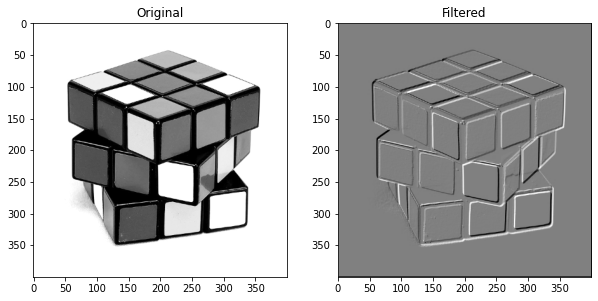

In [69]:
fsize = (10,6)
plt.figure(figsize = fsize)
plt.subplot(121),plt.imshow(im, 'gray'), plt.title('Original')
plt.subplot(122),plt.imshow(filtered_im, 'gray'), plt.title('Filtered')